# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import janitor as jn

from seaborn import diverging_palette
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)
from clf_score import clf_score
import mlflow

# Load dataset

In [2]:
df = pd.read_csv('bank_marketing_dataset.csv')
df.head(5)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  subscribed  
0          93.994          -36.4      4.857       5191.0          no  
1          93.994          -36.4      4.857       5191.0          no  
2          93.994          -36.4      4.857       5191.0          no  
3          93.994          -36.4      4.857       5191.0          no  
4          93.994          -36.4      4.857       5191.0          no  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Create the target

In [4]:
target = [
    1 if i == 'yes'
    else 0
    for i in df['subscribed']
]

df['target'] = target
df['target'].value_counts()

target
0    36548
1     4640
Name: count, dtype: int64

In [5]:
df.drop('subscribed', axis=1, inplace=True)

# Data clean up

In [6]:
df.drop(['duration'],
        axis=1,
        inplace=True)

# this attribute highly affects the output target (e.g., if duration=0 then y='no'). 

### Correlations

In [7]:
numerical_cols_c = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

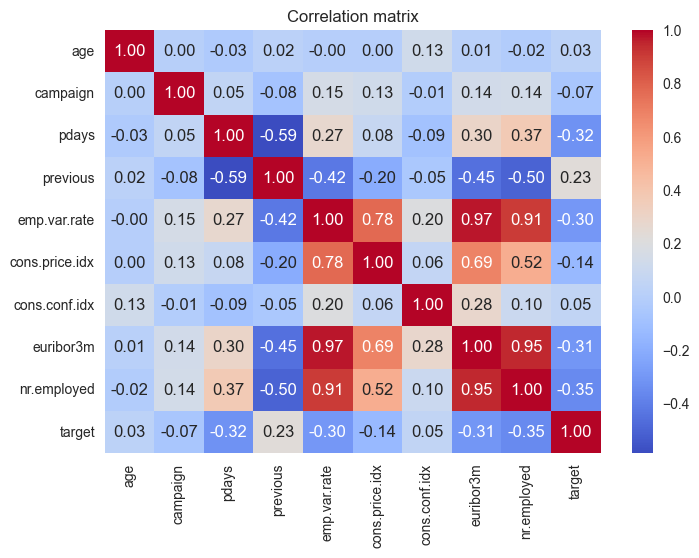

In [8]:
# Correlation matrix
corr = df[numerical_cols_c].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [9]:
# nr.employed, euribor3m and emp.var.rate are all highly correlated. Let's only keep nr.employed
df = df.drop(columns=['euribor3m', 'emp.var.rate'])

# Categorical encoding

In [10]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
numeric_cols

Index(['age', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'target'],
      dtype='object')

In [11]:
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

### Label encode for categories that have less than two values

In [12]:
from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print(col)

print('%d columns were label encoded.' % count)

contact
1 columns were label encoded.


Now, contact = 1 if telephone and 0 if cellular

### One-hot encoding the rest of categorical columns

In [13]:
df = pd.get_dummies(df)
print(df.shape)

(41188, 60)


In [14]:
for col in df.columns:
    print(col)

age
contact
campaign
pdays
previous
cons.price.idx
cons.conf.idx
nr.employed
target
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
marital_unknown
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_illiterate
education_professional.course
education_university.degree
education_unknown
default_no
default_unknown
default_yes
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
month_apr
month_aug
month_dec
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent
poutcome_success


## Seperate features and target

In [15]:
#pip install pyjanitor
import janitor as jn

In [16]:
X, y = jn.ml.get_features_targets(df, target_columns="target")

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\janitor\utils.py:367: DeprecationWarning: target_columns is deprecated; use target_column_names
  warn(


## Train test split

In [17]:

X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X, y, test_size = 0.3, random_state=42)



In [18]:
print(len(X_train))
print(len(X_val_test))
print(len(y_train))
print(len(y_val_test))

28831
12357
28831
12357


## Test validation split

In [19]:

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)



In [20]:
print(len(X_val))
print(len(X_test))
print(len(y_val))
print(len(y_test))

6178
6179
6178
6179


# Baseline Model - DummyClassifier

Unbalanced, not standardized

In [21]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [22]:
# accuracy
print('accuracy:')
print(dummy_clf.score(X_val, y_val)) 

# precision
from sklearn import metrics
print('precision:')
print(metrics.precision_score(y_val, dummy_clf.predict(X_val)))

accuracy:
0.8870184525736484
precision:
0.0


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = dummy_clf.predict(X_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5480    0]
 [ 698    0]]


# Standardize data

In [24]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Balance target variable

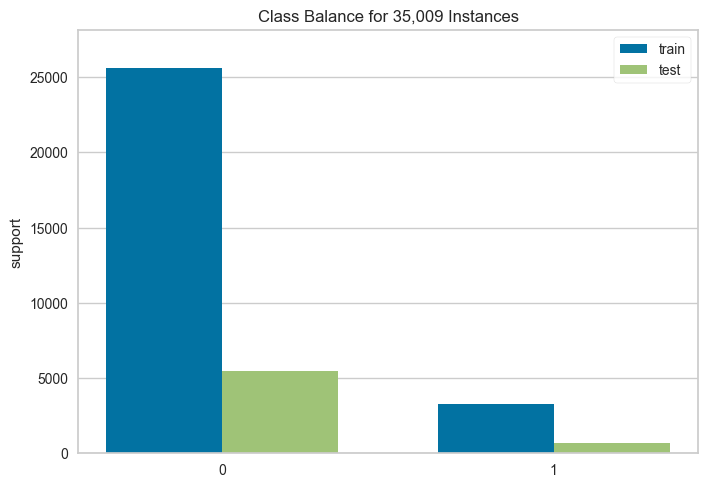

<Axes: title={'center': 'Class Balance for 35,009 Instances'}, ylabel='support'>

In [25]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Up-sample the training data

In [26]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

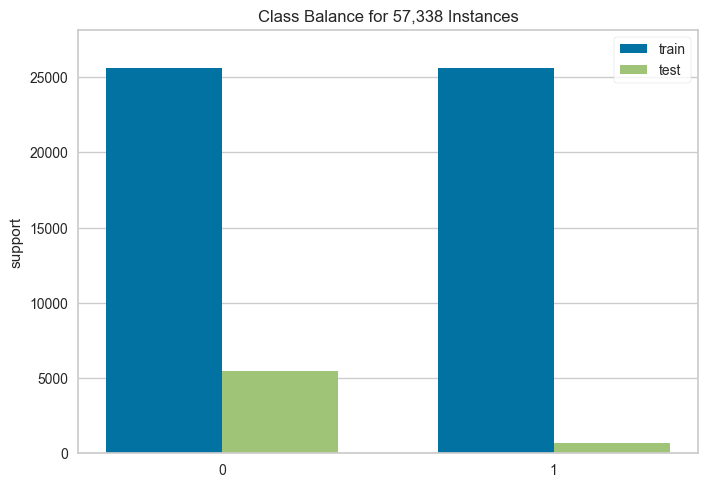

<Axes: title={'center': 'Class Balance for 57,338 Instances'}, ylabel='support'>

In [27]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train_sm, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# XGBoost

Experiment ID: 973657327246437769
Validation Result:

accuracy score: 0.8935



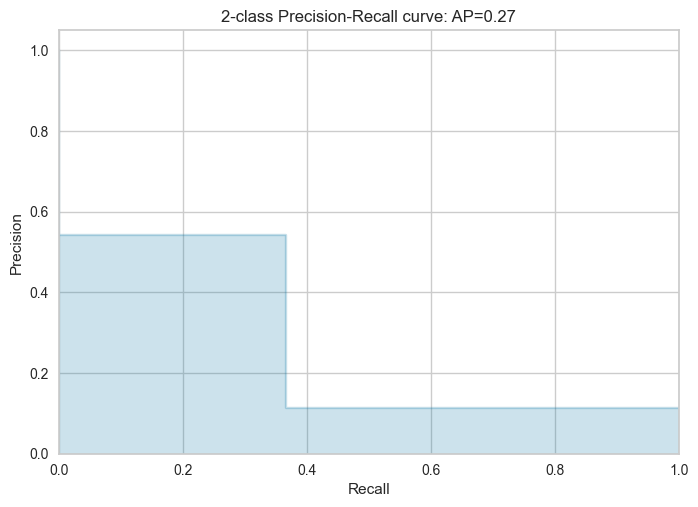

roc auc score: 0.6636730596281345



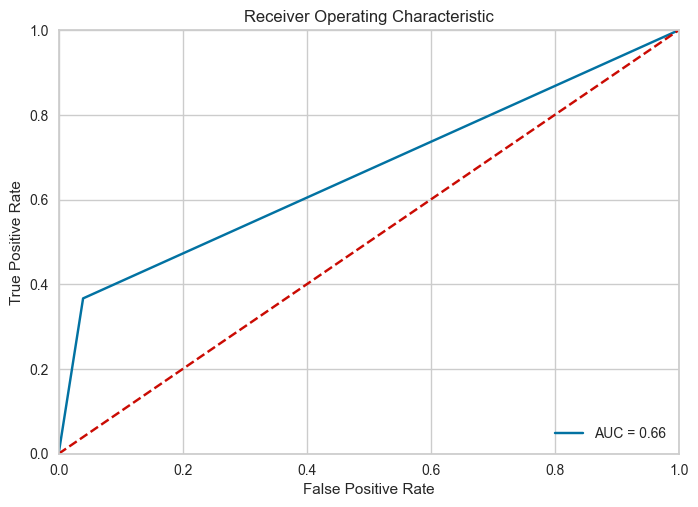

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5480
           1       0.54      0.37      0.44       698

    accuracy                           0.89      6178
   macro avg       0.73      0.66      0.69      6178
weighted avg       0.88      0.89      0.88      6178


Confusion Matrix: 
 [[5264  216]
 [ 442  256]]



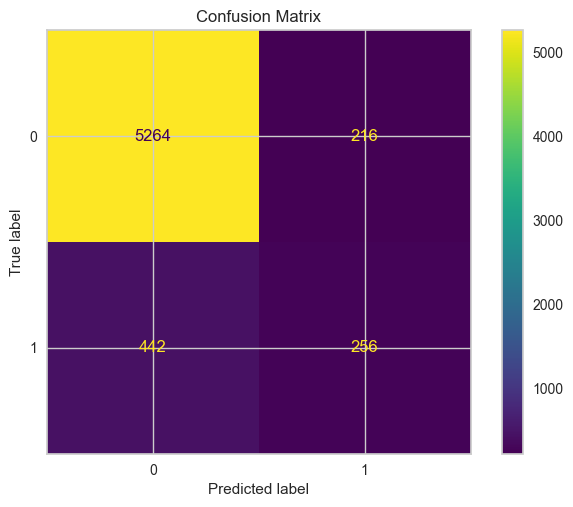

End of validation Result



c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'xgb_classification' already exists. Creating a new version of this model...
2024/05/02 22:07:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model ve

Test Accuracy: 0.8904
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5488
           1       0.51      0.36      0.42       691

    accuracy                           0.89      6179
   macro avg       0.72      0.66      0.68      6179
weighted avg       0.88      0.89      0.88      6179



Created version '7' of model 'xgb_classification'.


In [34]:
import xgboost as xgb
from evaluation_metric import clf_score
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, classification_report

mlflow.set_tracking_uri("http://127.0.0.1:5000")
client = MlflowClient()

experiment_name = "Classification Model"

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    experiment_id = experiment.experiment_id
else:
    experiment_id = mlflow.create_experiment(experiment_name)
print("Experiment ID:", experiment_id)

mlflow.start_run(experiment_id=experiment_id)
mlflow.log_param("random_state", 42)
mlflow.log_param("test_size", 0.15)
mlflow.log_param("train_size", 0.7)
mlflow.log_param("val_size", 0.15)


clf_xgb = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb.fit(X_train_sm, y_train_sm)
clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)
mlflow.log_param("colsample_bytree", 0.8)
mlflow.log_param("learning_rate", 0.2)
mlflow.log_param("max_depth", 7)
mlflow.log_param("n_estimators", 100)
mlflow.log_param("subsample", 1.0)
mlflow.xgboost.log_model(clf_xgb, "xgb_classification")
run_id = mlflow.active_run().info.run_id
model_uri = f"runs:/{run_id}/xgb_classification"
model_details = mlflow.register_model(model_uri, "xgb_classification")
y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
mlflow.log_metric("test_accuracy", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))





In [35]:
mlflow.end_run()

# Hyperparameter tuning - Optuna

In [38]:
#!pip install optuna

In [49]:
import mlflow
import mlflow.xgboost
from optuna.integration.mlflow import MLflowCallback
import optuna
from sklearn.metrics import accuracy_score
import uuid
import xgboost as xgb

mlflow.set_tracking_uri("http://127.0.0.1:5000")

experiment_name = f"xgboost_hyperparameter_optimization_{uuid.uuid4()}"

experiment_id = mlflow.create_experiment(experiment_name)

print("Experiment Name:", experiment_name)
print("Experiment ID:", experiment_id)

def objective(trial):
    with mlflow.start_run(experiment_id=experiment_id, nested=True):
        params = {
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'random_state': 42
        }

        clf_xgb = xgb.XGBClassifier(**params)
        clf_xgb.fit(X_train_sm, y_train_sm)
        
        y_val_pred = clf_xgb.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.xgboost.log_model(clf_xgb, "model", registered_model_name="XGBoost_Optuna")

        return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

mlflow.end_run()

[I 2024-05-02 23:11:22,754] A new study created in memory with name: no-name-519b6c55-033e-4131-beb7-ef391fa819f1


Experiment Name: xgboost_hyperparameter_optimization_844b6307-4703-4b9b-b947-35cba9dfd852
Experiment ID: 307760215150700072


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Optuna' already exists. Creating a new version of this model...
2024/05/02 23:11:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model versio

Best Hyperparameters: {'colsample_bytree': 0.10432183180977002, 'learning_rate': 0.26018946583402675, 'max_depth': 4, 'n_estimators': 117, 'subsample': 0.7949245302225275}


# Hyperparameter tuning - Bayesian Optimization

In [84]:
#!pip install bayesian-optimization

In [55]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
import mlflow
import mlflow.xgboost

mlflow.set_tracking_uri("http://127.0.0.1:5000")  
mlflow.set_experiment("XGBoost_Hyperparameter_Bayesian_Optimization") 

def objective_function(colsample_bytree, learning_rate, max_depth, n_estimators, subsample):
    with mlflow.start_run():
        params = {
            'colsample_bytree': colsample_bytree,
            'learning_rate': learning_rate,
            'max_depth': int(max_depth),
            'n_estimators': int(n_estimators),
            'subsample': subsample,
            'random_state': 42
        }
        
        mlflow.log_params(params)

        clf_xgb = xgb.XGBClassifier(**params)
        clf_xgb.fit(X_train_sm, y_train_sm)
        
        y_val_pred = clf_xgb.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        
        mlflow.log_metric("accuracy", accuracy)
        
        mlflow.xgboost.log_model(clf_xgb, "model",registered_model_name="XGBoost_Bayesian")

        return accuracy

pbounds = {
    'colsample_bytree': (0.1, 1.0),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 200),
    'subsample': (0.5, 1.0)
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=10,  
    n_iter=100,      
)

best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)
mlflow.end_run()

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Successfully registered model 'XGBoost_Bayesian'.
2024/05/03 00:05:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoos

| 1         | 0.8899    | 0.4371    | 0.2857    | 8.124     | 139.8     | 0.578     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 2         | 0.8946    | 0.2404    | 0.02684   | 9.063     | 140.2     | 0.854     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 3         | 0.8983    | 0.1185    | 0.2913    | 8.827     | 81.85     | 0.5909    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 4         | 0.8946    | 0.2651    | 0.09823   | 6.673     | 114.8     | 0.6456    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 5         | 0.8867    | 0.6507    | 0.05045   | 5.045     | 105.0     | 0.728     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 6         | 0.8946    | 0.8067    | 0.06791   | 6.6       | 138.9     | 0.5232    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 7         | 0.8869    | 0.6468    | 0.05945   | 3.455     | 192.3     | 0.9828    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 8         | 0.8919    | 0.8276    | 0.09834   | 3.684     | 152.6     | 0.7201    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 9         | 0.8998    | 0.2098    | 0.1536    | 3.241     | 186.4     | 0.6294    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 10        | 0.8985    | 0.6963    | 0.1004    | 6.64      | 132.0     | 0.5924    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 11        | 0.8907    | 0.7781    | 0.04842   | 6.828     | 131.9     | 0.5447    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:05:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 12        | 0.8856    | 0.9157    | 0.04055   | 4.031     | 188.8     | 0.8854    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 13        | 0.8457    | 0.6256    | 0.02386   | 3.251     | 65.68     | 0.6166    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 14        | 0.8972    | 0.4688    | 0.2448    | 6.118     | 132.2     | 0.7249    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 15        | 0.8689    | 0.3848    | 0.01964   | 3.769     | 185.8     | 0.5096    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 16        | 0.8945    | 0.2663    | 0.06143   | 6.77      | 132.2     | 0.7226    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 17        | 0.8975    | 0.1679    | 0.2455    | 6.267     | 95.87     | 0.6494    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 18        | 0.8967    | 0.1694    | 0.1808    | 9.018     | 140.2     | 0.8405    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 19        | 0.8987    | 0.4605    | 0.2177    | 3.242     | 186.9     | 0.8985    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 20        | 0.8964    | 0.2202    | 0.2238    | 5.109     | 78.43     | 0.6134    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 21        | 0.8979    | 0.3443    | 0.199     | 3.435     | 162.1     | 0.9796    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 22        | 0.9011    | 0.1       | 0.3       | 3.0       | 187.0     | 0.5       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 23        | 0.8972    | 0.1671    | 0.2943    | 8.57      | 80.95     | 0.7935    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 24        | 0.899     | 0.5551    | 0.1584    | 8.54      | 99.56     | 0.9612    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 25        | 0.8956    | 0.7477    | 0.2078    | 9.354     | 81.44     | 0.8487    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 26        | 0.8975    | 0.6675    | 0.1454    | 8.101     | 81.82     | 0.9529    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:06:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 27        | 0.8689    | 0.6095    | 0.02513   | 5.549     | 74.49     | 0.5775    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 28        | 0.8979    | 0.2278    | 0.2222    | 7.957     | 98.79     | 0.8635    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 29        | 0.8954    | 0.3451    | 0.1973    | 9.045     | 98.74     | 0.6315    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 30        | 0.8933    | 0.9852    | 0.08702   | 7.592     | 99.74     | 0.6553    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 31        | 0.8995    | 0.1       | 0.3       | 7.508     | 81.34     | 0.5       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 32        | 0.8943    | 0.7301    | 0.1538    | 7.471     | 80.66     | 0.6222    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 33        | 0.898     | 0.2545    | 0.2472    | 6.62      | 82.19     | 0.519     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 34        | 0.8987    | 0.1104    | 0.1674    | 7.768     | 82.5      | 0.575     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 35        | 0.8949    | 0.8337    | 0.2401    | 7.155     | 83.04     | 0.6797    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 36        | 0.8943    | 0.3376    | 0.2574    | 8.724     | 83.11     | 0.765     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 37        | 0.8967    | 0.4506    | 0.2954    | 6.15      | 81.18     | 0.7423    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 38        | 0.883     | 0.955     | 0.03688   | 5.778     | 131.4     | 0.849     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 39        | 0.8972    | 0.9508    | 0.2312    | 7.244     | 81.77     | 0.703     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 40        | 0.8945    | 0.4117    | 0.07473   | 9.37      | 100.2     | 0.7246    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 41        | 0.8961    | 0.8839    | 0.2533    | 6.362     | 133.0     | 0.6311    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:07:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 42        | 0.8979    | 0.448     | 0.1425    | 4.395     | 161.5     | 0.8588    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 43        | 0.8946    | 0.4877    | 0.2143    | 9.319     | 143.1     | 0.5351    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 44        | 0.8943    | 0.6431    | 0.1097    | 3.394     | 161.0     | 0.9827    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 45        | 0.8758    | 0.3564    | 0.02413   | 3.668     | 184.8     | 0.9869    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 46        | 0.8975    | 0.9565    | 0.1953    | 4.399     | 162.8     | 0.9624    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 47        | 0.8967    | 0.7679    | 0.2577    | 3.136     | 163.2     | 0.6734    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 48        | 0.8768    | 0.167     | 0.01906   | 5.597     | 162.0     | 0.762     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 49        | 0.8977    | 0.2167    | 0.2003    | 7.072     | 96.95     | 0.6579    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 50        | 0.8954    | 0.8224    | 0.2037    | 5.993     | 97.08     | 0.6418    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 51        | 0.8985    | 0.8245    | 0.2991    | 7.185     | 95.72     | 0.7932    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 52        | 0.8969    | 0.3236    | 0.2437    | 8.458     | 96.22     | 0.5815    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 53        | 0.8838    | 0.1       | 0.01      | 7.626     | 95.11     | 0.5       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 54        | 0.8796    | 0.7624    | 0.02302   | 8.617     | 97.28     | 0.9775    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 55        | 0.8982    | 0.3568    | 0.1663    | 4.043     | 163.9     | 0.9776    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:08:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 56        | 0.8954    | 0.9601    | 0.1176    | 6.832     | 96.41     | 0.5108    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 57        | 0.8812    | 0.159     | 0.04877   | 3.891     | 162.9     | 0.956     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 58        | 0.8972    | 0.7396    | 0.231     | 3.56      | 164.6     | 0.7096    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 59        | 0.8992    | 0.9673    | 0.2989    | 4.542     | 164.1     | 0.5667    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 60        | 0.9001    | 0.2089    | 0.2588    | 4.53      | 165.0     | 0.7605    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 61        | 0.8946    | 0.458     | 0.2589    | 9.69      | 156.6     | 0.7979    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 62        | 0.8962    | 0.7168    | 0.2028    | 9.325     | 81.31     | 0.9008    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 63        | 0.8642    | 0.3832    | 0.01      | 5.167     | 164.4     | 1.0       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 64        | 0.8974    | 0.27      | 0.2691    | 7.632     | 127.2     | 0.8637    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 65        | 0.8992    | 0.3581    | 0.2341    | 4.143     | 165.7     | 0.642     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 66        | 0.8959    | 0.8456    | 0.1513    | 3.904     | 163.8     | 0.5903    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 67        | 0.8851    | 0.1       | 0.01      | 7.286     | 81.94     | 0.5       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 68        | 0.864     | 0.9679    | 0.0131    | 4.372     | 165.1     | 0.6032    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 69        | 0.854     | 0.3937    | 0.01164   | 4.249     | 119.0     | 0.9179    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:09:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 70        | 0.8966    | 0.798     | 0.1884    | 6.057     | 179.4     | 0.763     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 71        | 0.8977    | 0.2416    | 0.2729    | 5.587     | 133.3     | 0.8316    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 72        | 0.8865    | 0.8251    | 0.0353    | 5.38      | 174.0     | 0.8977    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 73        | 0.9003    | 0.1689    | 0.1761    | 3.786     | 164.7     | 0.8983    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 74        | 0.8956    | 0.7534    | 0.294     | 6.115     | 82.09     | 0.6817    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 75        | 0.8977    | 0.3468    | 0.2815    | 3.279     | 164.2     | 0.8109    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 76        | 0.9008    | 0.1       | 0.3       | 3.644     | 165.3     | 0.5       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 77        | 0.8998    | 0.217     | 0.1803    | 3.628     | 166.4     | 0.9111    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 78        | 0.8919    | 0.1376    | 0.07395   | 3.79      | 165.7     | 0.9222    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 79        | 0.8962    | 0.4328    | 0.1333    | 4.17      | 166.7     | 0.6422    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 80        | 0.8975    | 0.303     | 0.09069   | 6.246     | 189.9     | 0.5742    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 81        | 0.8975    | 1.0       | 0.3       | 3.921     | 161.9     | 0.8628    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 82        | 0.8951    | 0.9362    | 0.2738    | 7.366     | 85.54     | 0.7175    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 83        | 0.8966    | 0.9913    | 0.2571    | 7.803     | 82.52     | 0.6316    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 84        | 0.8949    | 0.2328    | 0.05632   | 4.636     | 197.0     | 0.853     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:10:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 85        | 0.8979    | 0.1812    | 0.1637    | 3.083     | 167.0     | 0.8354    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 86        | 0.8916    | 0.7956    | 0.2302    | 9.515     | 193.0     | 0.8215    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 87        | 0.8953    | 0.7089    | 0.1066    | 9.536     | 175.1     | 0.9698    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 88        | 0.8985    | 0.2652    | 0.2666    | 3.703     | 187.3     | 0.5128    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 89        | 0.8974    | 0.1892    | 0.2575    | 7.202     | 96.13     | 0.5673    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 90        | 0.8982    | 0.7165    | 0.2317    | 3.322     | 166.3     | 0.5329    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 91        | 0.8958    | 0.3049    | 0.09933   | 8.714     | 131.5     | 0.5588    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 92        | 0.8974    | 0.9982    | 0.3       | 6.34      | 95.64     | 1.0       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 93        | 0.899     | 0.1174    | 0.1508    | 4.959     | 166.0     | 0.826     |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 94        | 0.8953    | 0.903     | 0.1138    | 9.527     | 53.84     | 0.8051    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 95        | 0.8983    | 0.1       | 0.3       | 7.746     | 83.16     | 1.0       |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 96        | 0.8953    | 0.9137    | 0.1363    | 4.942     | 141.0     | 0.9231    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 97        | 0.8835    | 0.5515    | 0.0203    | 6.979     | 178.9     | 0.7179    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 98        | 0.8949    | 0.5128    | 0.2626    | 8.166     | 84.68     | 0.8217    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:11:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 99        | 0.8613    | 0.6884    | 0.01537   | 3.05      | 187.5     | 0.5571    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 100       | 0.8949    | 0.9599    | 0.2541    | 8.355     | 81.14     | 0.7101    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 101       | 0.892     | 0.3263    | 0.04582   | 8.253     | 82.52     | 0.8728    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 102       | 0.8953    | 0.8073    | 0.2047    | 5.171     | 67.58     | 0.8518    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 103       | 0.8975    | 0.5109    | 0.1733    | 3.009     | 165.2     | 0.5812    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 104       | 0.8998    | 0.1494    | 0.2325    | 3.217     | 186.3     | 0.5836    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 105       | 0.8953    | 0.9158    | 0.07964   | 8.124     | 98.96     | 0.9083    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 106       | 0.9003    | 0.1122    | 0.1894    | 3.83      | 187.0     | 0.9713    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 107       | 0.8946    | 0.3492    | 0.2339    | 6.521     | 135.0     | 0.5905    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 108       | 0.8935    | 0.6483    | 0.03795   | 6.37      | 180.0     | 0.5707    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 109       | 0.8893    | 0.8675    | 0.2837    | 8.783     | 170.3     | 0.6194    |


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'XGBoost_Bayesian' already exists. Creating a new version of this model...
2024/05/03 00:12:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model vers

| 110       | 0.8911    | 0.8785    | 0.089     | 3.074     | 162.0     | 0.5838    |
Best Hyperparameters: {'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3.0, 'n_estimators': 186.98614968638898, 'subsample': 0.5}


Created version '110' of model 'XGBoost_Bayesian'.


In [64]:
mlflow.end_run()

# Best model: XGBoost from Optuna

Experiment ID: 772420319166288301
Validation Result:

accuracy score: 0.9000



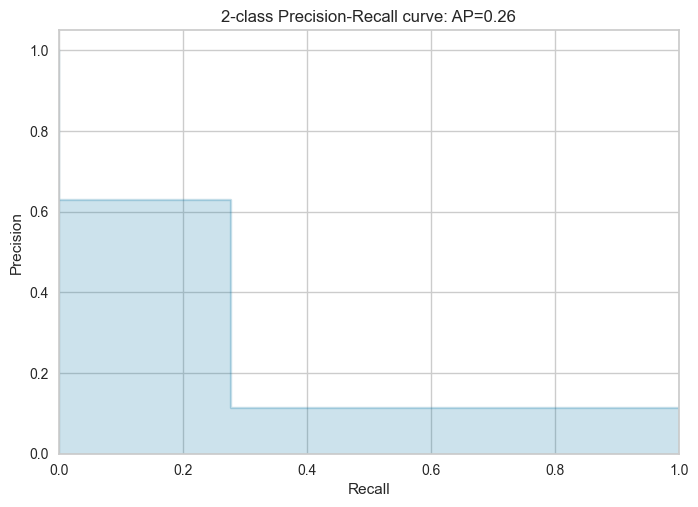

roc auc score: 0.6285670215213436



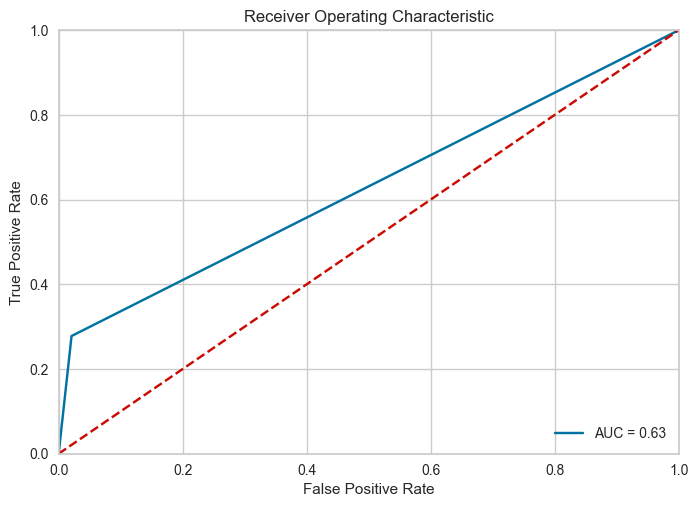

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      5480
           1       0.63      0.28      0.39       698

    accuracy                           0.90      6178
   macro avg       0.77      0.63      0.67      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5366  114]
 [ 504  194]]



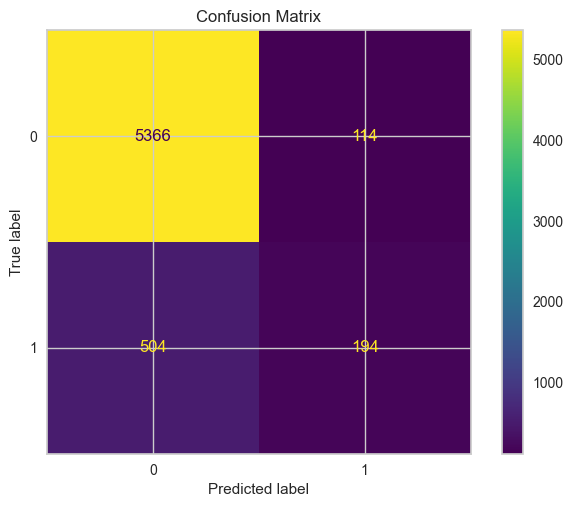

End of validation Result



c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\mlflow\models\model.py:299: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'xgb_classification' already exists. Creating a new version of this model...
2024/05/03 00:20:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model ve

Test Accuracy: 0.8984
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5488
           1       0.60      0.27      0.37       691

    accuracy                           0.90      6179
   macro avg       0.76      0.62      0.66      6179
weighted avg       0.88      0.90      0.88      6179



Created version '8' of model 'xgb_classification'.


In [65]:

mlflow.set_tracking_uri("http://127.0.0.1:5000")
client = MlflowClient()

experiment_name = "Classification Best Model"

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    experiment_id = experiment.experiment_id
else:
    experiment_id = mlflow.create_experiment(experiment_name)
print("Experiment ID:", experiment_id)
mlflow.start_run(experiment_id=experiment_id)
mlflow.log_param("random_state", 42)
mlflow.log_param("test_size", 0.15)
mlflow.log_param("train_size", 0.7)
mlflow.log_param("val_size", 0.15)

clf_xgb = xgb.XGBClassifier(colsample_bytree=0.10432183180977002, learning_rate=0.26018946583402675, max_depth=4, n_estimators=117, subsample=0.7949245302225275)
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

mlflow.log_param("colsample_bytree", 0.1)
mlflow.log_param("learning_rate", 0.3)
mlflow.log_param("max_depth", 3)
mlflow.log_param("n_estimators", 186.98614968638898)
mlflow.log_param("subsample", 0.5)
mlflow.xgboost.log_model(clf_xgb, "xgb_classification")
run_id = mlflow.active_run().info.run_id
model_uri = f"runs:/{run_id}/xgb_classification"
model_details = mlflow.register_model(model_uri, "xgb_classification")
y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
mlflow.log_metric("test_accuracy", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
mlflow.end_run()

### Evaluate model on test set

In [66]:
from sklearn.metrics import accuracy_score, classification_report

y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8984


#### Classification report

In [67]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5488
           1       0.60      0.27      0.37       691

    accuracy                           0.90      6179
   macro avg       0.76      0.62      0.66      6179
weighted avg       0.88      0.90      0.88      6179



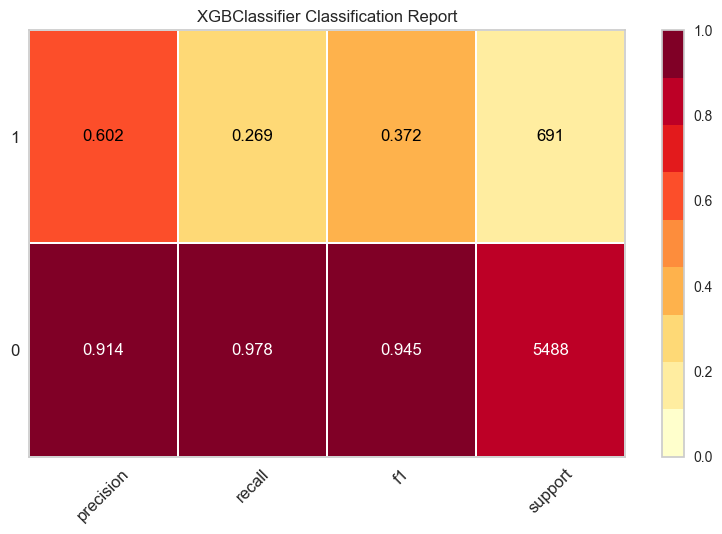

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [68]:
from yellowbrick.classifier import ClassificationReport

classes = ["0", "1"]

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion matrix

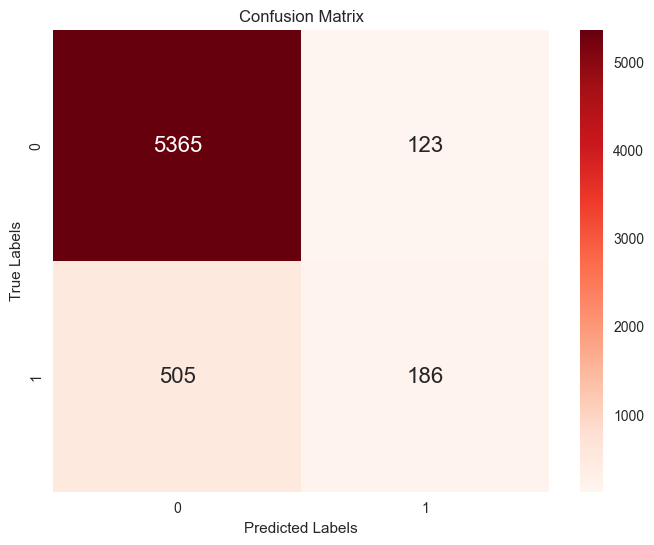

In [69]:
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### PR Curve

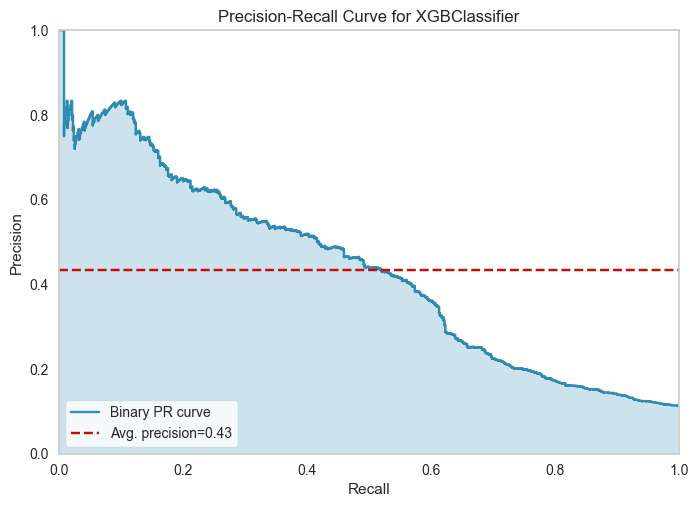

<Axes: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [70]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
viz.fit(X_train_sm, y_train_sm)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

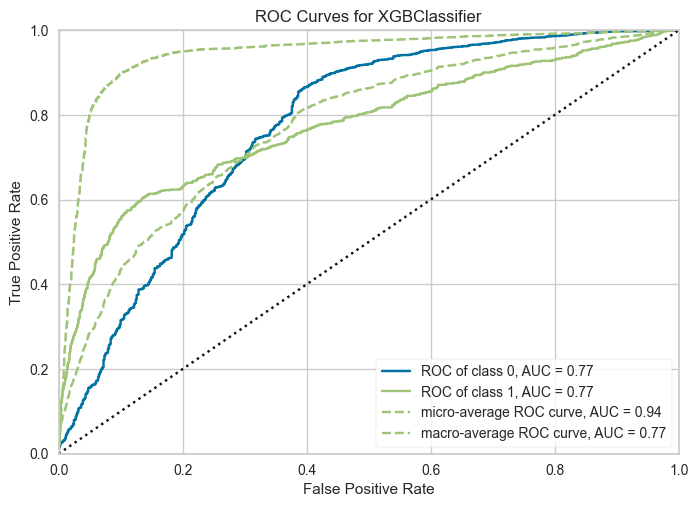

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [71]:
visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Validation curve

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


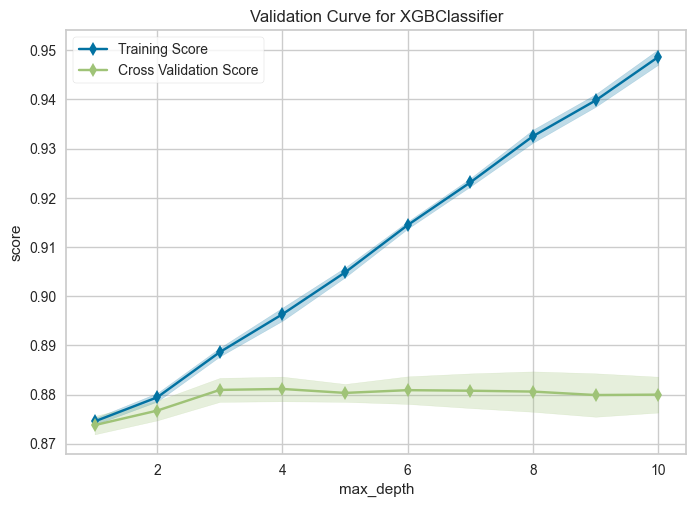

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [72]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

#### Learning curve

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


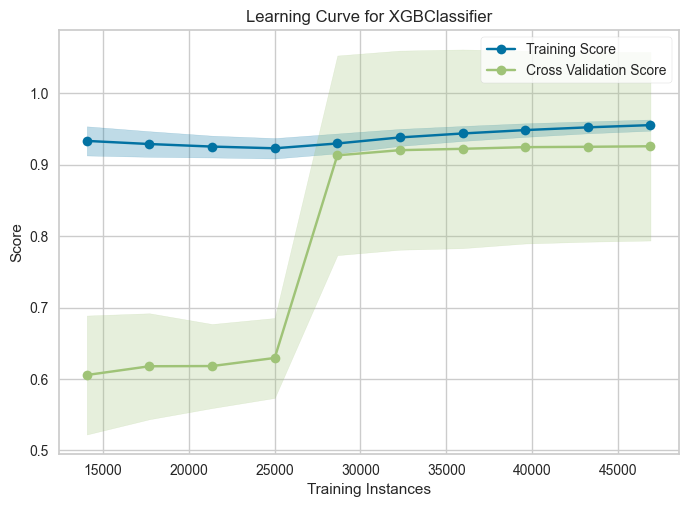

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [73]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the data to the visualizer
visualizer.poof()                       # Finalize and render the figure

#### Discrimination Threshold

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


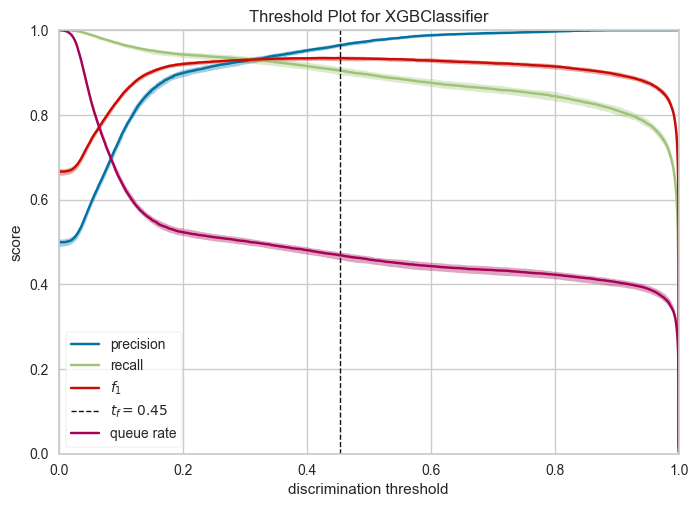

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [74]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_xgb, is_fitted=True)

visualizer.fit(X_train_sm, y_train_sm)
visualizer.poof() 

#### Decision Function

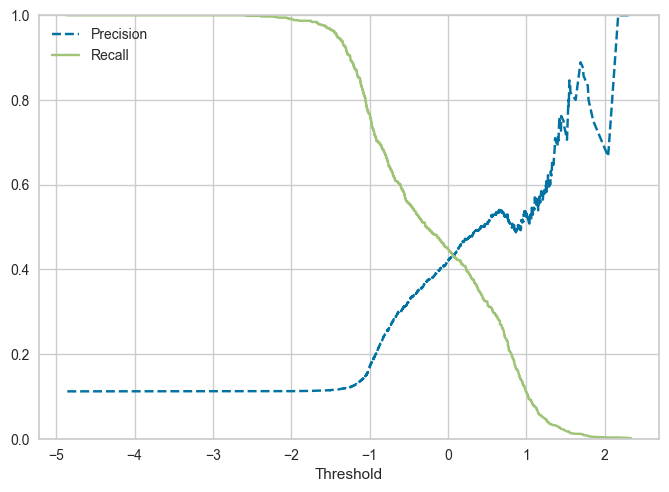

In [75]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

clf_svc = SVC(gamma='auto')
clf_svc.fit(X_train_sm, y_train_sm)

# call decision_function on classifier to get scores (probas_pred)
probas_pred = clf_svc.decision_function(X_test)
# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred)
# precision and recall vs. the decision threshold
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#### Feature importance

<Axes: >

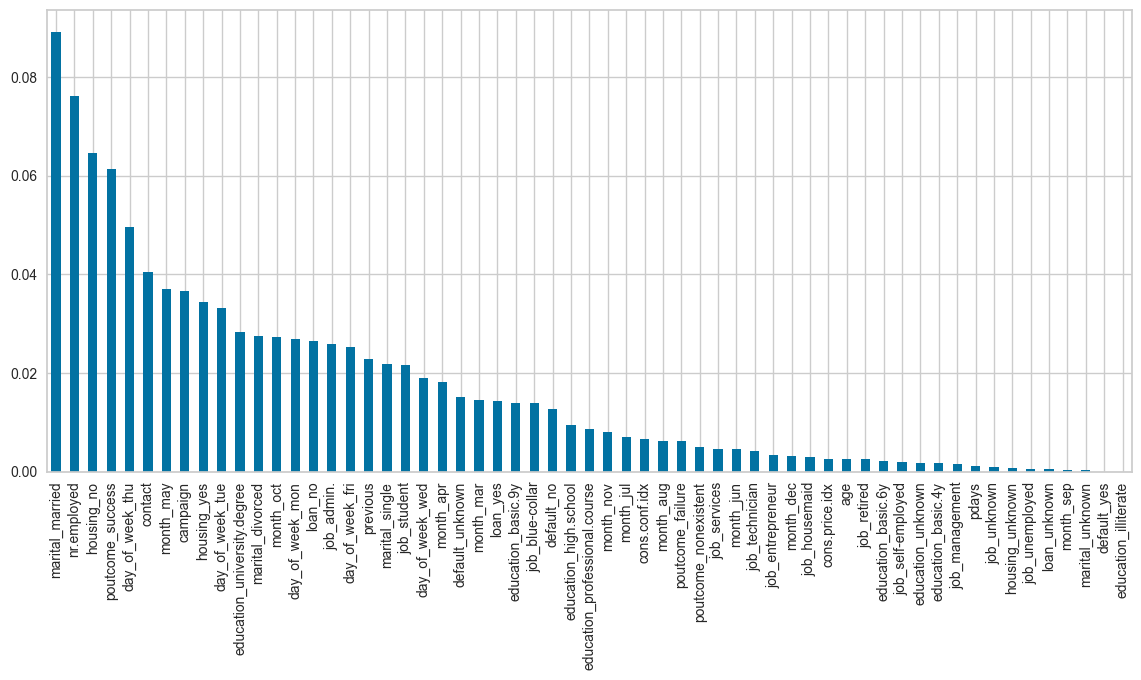

In [76]:
# Print feature importance
pd.Series(clf_xgb.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))


In [105]:
#pip install shap


# Explainability - SHAP

[00:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


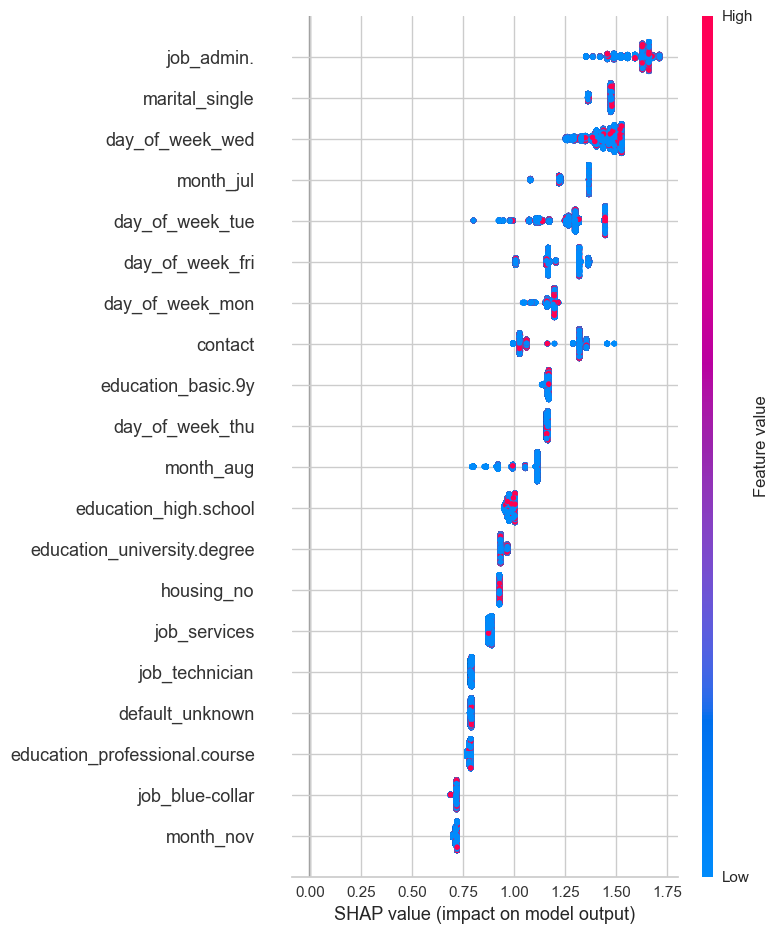

In [77]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=X.columns)

[00:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


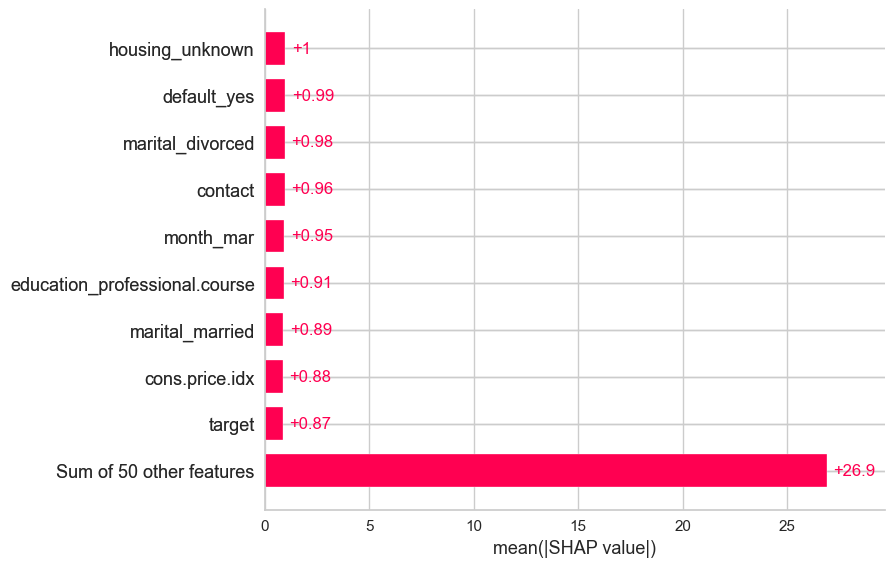

In [78]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(clf_xgb, X_train_sm)

# Compute SHAP values
shap_values = explainer.shap_values(X_val)

# Convert SHAP values to Explanation object with feature names
shap_explainer = shap.Explanation(X_val, shap_values, feature_names=df.columns)

# Plot the bar plot
shap.plots.bar(shap_explainer)

[00:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


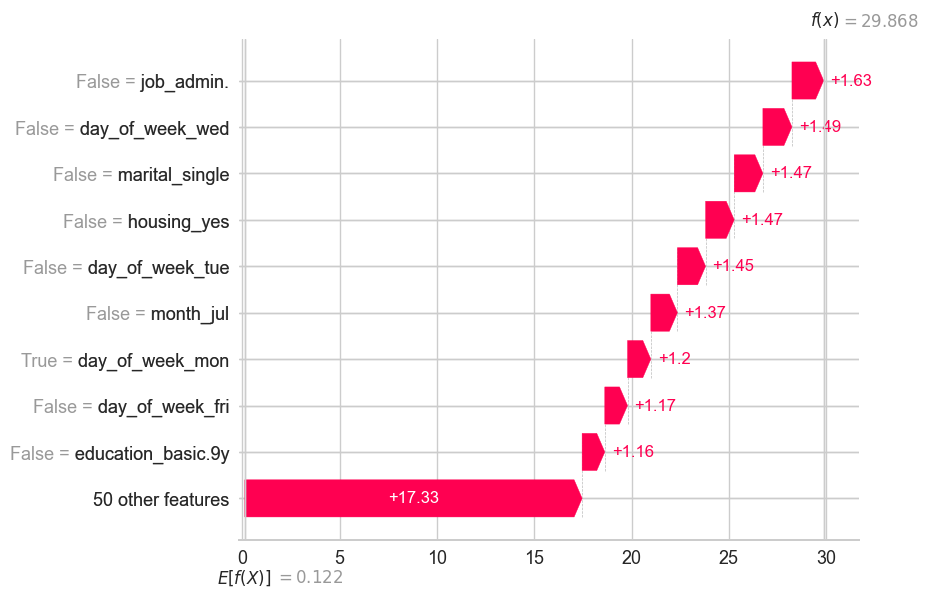

In [79]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [122]:
shap.initjs()

In [80]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [81]:
# visualize some training set predictions
shap.plots.force(shap_values[:500])

# Explainability - LIME

In [82]:
#pip install lime

In [83]:
import lime
import lime.lime_tabular

# Create a LimeTabularExplainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_sm,
    feature_names=list(df.columns),
    class_names=['Not Subscribed', 'Subscribed'],
    discretize_continuous=True
)

ModuleNotFoundError: No module named 'lime'

In [ ]:
# Choose an instance from your test data to explain
instance_idx = 5  # Choose the index of the instance you want to explain

# Get the prediction function for your XGBoost model
predict_fn = lambda x: clf_xgb.predict_proba(x).astype(float)

In [ ]:
# Generate an explanation for the chosen instance
explanation = explainer.explain_instance(
    X_test[instance_idx],
    predict_fn,
    num_features=len(df.columns)
)

# Show the explanation
explanation.show_in_notebook()

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


# Data drift

We don't have any date feature (we have the months and days but not the years...), so we can't really analyze the changes in the distribution of input data over time to see make an analysis of its impact on model performance and reliability. However, for the sake of the project and so we can at least try, we did a KS test on some sample data.

#### Kolmogorov-Smirnov (KS) Test

In [132]:
# Ensure X_train has the same number of columns (excluding 'target') as the original DataFrame
X_train_subset = X_train[:, :len(df.columns) - 1]  # Exclude 'target' column

# Get column names excluding 'target'
column_names = df.drop(columns=['target']).columns

# Convert the subset of X_train to a DataFrame with column names
df_train = pd.DataFrame(X_train_subset, columns=column_names)

# Define df_val using the validation data
X_val_subset = X_val[:, :len(df.columns) - 1]  # Exclude 'target' column
df_val = pd.DataFrame(X_val_subset, columns=column_names)

In [133]:
from scipy.stats import ks_2samp

# Define the detect_drift function
def detect_drift(df_train, df_test, numeric_cols):
    drift_results = {}
    for col in numeric_cols:
        if col in df_train.columns and col in df_test.columns:
            statistic, p_value = ks_2samp(df_train[col], df_test[col])
            drift_results[col] = {'KS Statistic': statistic, 'P-value': p_value}
        else:
            print(f"Warning: Feature '{col}' is not present in both datasets.")
    return drift_results

In [134]:
# Detect drift between training and validation/test sets
drift_results_val = detect_drift(df_train, df_val, numeric_cols)
drift_results_test = detect_drift(df_train, pd.DataFrame(X_test, columns=df.columns[:-1]), numeric_cols)

In [135]:
# Display drift detection results
print("Drift detection results for validation set:")
for feature, result in drift_results_val.items():
    print(f"Feature: {feature}, KS Statistic: {result['KS Statistic']}, P-value: {result['P-value']}")

print("\nDrift detection results for test set:")
for feature, result in drift_results_test.items():
    print(f"Feature: {feature}, KS Statistic: {result['KS Statistic']}, P-value: {result['P-value']}")

Drift detection results for validation set:
Feature: age, KS Statistic: 0.012390533331969433, P-value: 0.4121388508055448
Feature: campaign, KS Statistic: 0.009500088587381716, P-value: 0.7442805116651354
Feature: pdays, KS Statistic: 0.004000737309314384, P-value: 0.9999970796033144
Feature: previous, KS Statistic: 0.0032619907448053764, P-value: 0.999999997897541
Feature: cons.price.idx, KS Statistic: 0.007236015413115249, P-value: 0.9508973963991567
Feature: cons.conf.idx, KS Statistic: 0.006340271729428193, P-value: 0.9859248995980135
Feature: nr.employed, KS Statistic: 0.006311829896866419, P-value: 0.9866004386322524

Drift detection results for test set:
Feature: age, KS Statistic: 0.005836811537885511, P-value: 0.9947493745144582
Feature: campaign, KS Statistic: 0.012463163164431301, P-value: 0.40481470698726363
Feature: pdays, KS Statistic: 0.0017750422153367529, P-value: 1.0
Feature: previous, KS Statistic: 0.0008515226960442712, P-value: 1.0
Feature: cons.price.idx, KS Stati

In [136]:
import pandas as pd

# Define the drift detection results
drift_detection_results = {
    'Feature': [],
    'KS Statistic (Validation Set)': [],
    'P-value (Validation Set)': [],
    'KS Statistic (Test Set)': [],
    'P-value (Test Set)': []
}

# Update drift_detection_results with validation set results
for feature, result in drift_results_val.items():
    drift_detection_results['Feature'].append(feature)
    drift_detection_results['KS Statistic (Validation Set)'].append(result['KS Statistic'])
    drift_detection_results['P-value (Validation Set)'].append(result['P-value'])

# Update drift_detection_results with test set results
for feature, result in drift_results_test.items():
    index = drift_detection_results['Feature'].index(feature)
    drift_detection_results['KS Statistic (Test Set)'].insert(index, result['KS Statistic'])
    drift_detection_results['P-value (Test Set)'].insert(index, result['P-value'])

# Create DataFrame
df_drift_detection_results = pd.DataFrame(drift_detection_results)

df_drift_detection_results


Feature  KS Statistic (Validation Set)  P-value (Validation Set)  \
0             age                       0.012391                  0.412139   
1        campaign                       0.009500                  0.744281   
2           pdays                       0.004001                  0.999997   
3        previous                       0.003262                  1.000000   
4  cons.price.idx                       0.007236                  0.950897   
5   cons.conf.idx                       0.006340                  0.985925   
6     nr.employed                       0.006312                  0.986600   

   KS Statistic (Test Set)  P-value (Test Set)  
0                 0.005837            0.994749  
1                 0.012463            0.404815  
2                 0.001775            1.000000  
3                 0.000852            1.000000  
4                 0.007258            0.949678  
5                 0.011380            0.521411  
6                 0.015078            0.195679

Statistical Significance: Using statistical tests, such as hypothesis testing, to determine whether the observed differences are statistically significant based on chosen significance levels (e.g., α = 0.05).

Overall, these results indicate that most features exhibit little to no drift between the training and validation sets and between the training and test sets. However, it’s essential to monitor any significant changes over time to ensure model performance remains consistent.